In [2]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content


# What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you choose to work with that notebook).

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

**NOTE: This notebook is meant to teach you the latest version of Tensorflow which is as of this homework version `2.2.0-rc3`. Most examples on the web today are still in 1.x, so be careful not to confuse the two when looking up documentation**.

## Install Tensorflow 2.0 (ONLY IF YOU ARE WORKING LOCALLY)

1. Have the latest version of Anaconda installed on your machine.
2. Create a new conda environment starting from Python 3.7. In this setup example, we'll call it `tf_20_env`.
3. Run the command: `source activate tf_20_env`
4. Then pip install TF 2.0 as described here: https://www.tensorflow.org/install

# Table of Contents

This notebook has 5 parts. We will walk through TensorFlow at **three different levels of abstraction**, which should help you better understand it and prepare you for working on your project.

1. Part I, Preparation: load the CIFAR-10 dataset.
2. Part II, Barebone TensorFlow: **Abstraction Level 1**, we will work directly with low-level TensorFlow graphs. 
3. Part III, Keras Model API: **Abstraction Level 2**, we will use `tf.keras.Model` to define arbitrary neural network architecture. 
4. Part IV, Keras Sequential + Functional API: **Abstraction Level 3**, we will use `tf.keras.Sequential` to define a linear feed-forward network very conveniently, and then explore the functional libraries for building unique and uncommon models that require more flexibility.
5. Part V, CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features. 

We will discuss Keras in more detail later in the notebook.

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `tf.keras.Model`     | High        | Medium      |
| `tf.keras.Sequential` | Low         | High        |

# Part I: Preparation

First, we load the CIFAR-10 dataset. This might take a few minutes to download the first time you run it, but after that the files should be cached on disk and loading should be faster.

In previous parts of the assignment we used CS231N-specific code to download and read the CIFAR-10 dataset; however the `tf.keras.datasets` package in TensorFlow provides prebuilt utility functions for loading many common datasets.

For the purposes of this assignment we will still write our own code to preprocess the data and iterate through it in minibatches. The `tf.data` package in TensorFlow provides tools for automating this process, but working with this package adds extra complication and is beyond the scope of this notebook. However using `tf.data` can be much more efficient than the simple approach used in this notebook, so you should consider using it for your project.

In [3]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # cf. X_train.shape[0] = 50,000

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [5]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [6]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)


You can optionally **use GPU by setting the flag to True below**.

## Colab Users

If you are using Colab, you need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [7]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Part II: Barebones TensorFlow
TensorFlow ships with various high-level APIs which make it very convenient to define and train neural networks; we will cover some of these constructs in Part III and Part IV of this notebook. In this section we will start by building a model with basic TensorFlow constructs to help you better understand what's going on under the hood of the higher-level APIs.

**"Barebones Tensorflow" is important to understanding the building blocks of TensorFlow, but much of it involves concepts from TensorFlow 1.x.** We will be working with legacy modules such as `tf.Variable`.

Therefore, please read and understand the differences between legacy (1.x) TF and the new (2.0) TF.

### Historical background on TensorFlow 1.x

TensorFlow 1.x is primarily a framework for working with **static computational graphs**. Nodes in the computational graph are Tensors which will hold n-dimensional arrays when the graph is run; edges in the graph represent functions that will operate on Tensors when the graph is run to actually perform useful computation.

Before Tensorflow 2.0, we had to configure the graph into two phases. There are plenty of tutorials online that explain this two-step process. The process generally looks like the following for TF 1.x:
1. **Build a computational graph that describes the computation that you want to perform**. This stage doesn't actually perform any computation; it just builds up a symbolic representation of your computation. This stage will typically define one or more `placeholder` objects that represent inputs to the computational graph.
2. **Run the computational graph many times.** Each time the graph is run (e.g. for one gradient descent step) you will specify which parts of the graph you want to compute, and pass a `feed_dict` dictionary that will give concrete values to any `placeholder`s in the graph.

### The new paradigm in Tensorflow 2.0
Now, with Tensorflow 2.0, we can simply adopt a functional form that is more Pythonic and similar in spirit to PyTorch and direct Numpy operation. Instead of the 2-step paradigm with computation graphs, making it (among other things) easier to debug TF code. You can read more details at https://www.tensorflow.org/guide/eager.

The main difference between the TF 1.x and 2.0 approach is that the 2.0 approach doesn't make use of `tf.Session`, `tf.run`, `placeholder`, `feed_dict`. To get more details of what's different between the two version and how to convert between the two, check out the official migration guide: https://www.tensorflow.org/alpha/guide/migration_guide

Later, in the rest of this notebook we'll focus on this new, simpler approach.

### TensorFlow warmup: Flatten Function

We can see this in action by defining a simple `flatten` function that will reshape image data for use in a fully-connected network.

In TensorFlow, data for convolutional feature maps is typically stored in a Tensor of shape N x H x W x C where:

- N is the number of datapoints (minibatch size)
- H is the height of the feature map
- W is the width of the feature map
- C is the number of channels in the feature map

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `H x W x C` values per representation into a single long vector. 

Notice the `tf.reshape` call has the target shape as `(N, -1)`, meaning it will reshape/keep the first dimension to be N, and then infer as necessary what the second dimension is in the output, so we can collapse the remaining dimensions from the input properly.

**NOTE**: TensorFlow and PyTorch differ on the default Tensor layout; TensorFlow uses N x H x W x C but PyTorch uses N x C x H x W.

In [8]:
def flatten(x):
    """    
    Input:
    - TensorFlow Tensor of shape (N, D1, ..., DM)
    
    Output:
    - TensorFlow Tensor of shape (N, D1 * ... * DM)
    """
    N = tf.shape(x)[0]
    return tf.reshape(x, (N, -1))

In [9]:
def test_flatten():
    # Construct concrete values of the input data x using numpy
    x_np = np.arange(24).reshape((2, 3, 4))
    print('x_np:\n', x_np, '\n')
    # Compute a concrete output value.
    x_flat_np = flatten(x_np)
    print('x_flat_np:\n', x_flat_np, '\n')

test_flatten()

x_np:
 [[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]] 

x_flat_np:
 tf.Tensor(
[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]], shape=(2, 12), dtype=int64) 



### Barebones TensorFlow: Define a Two-Layer Network
We will now implement our first neural network with TensorFlow: a fully-connected ReLU network with two hidden layers and no biases on the CIFAR10 dataset. For now we will use only low-level TensorFlow operators to define the network; later we will see how to use the higher-level abstractions provided by `tf.keras` to simplify the process.

We will define the forward pass of the network in the function `two_layer_fc`; this will accept TensorFlow Tensors for the inputs and weights of the network, and return a TensorFlow Tensor for the scores. 

After defining the network architecture in the `two_layer_fc` function, we will test the implementation by checking the shape of the output.

**It's important that you read and understand this implementation.**

In [10]:
def two_layer_fc(x, params):
    """
    A fully-connected neural network; the architecture is:
    fully-connected layer -> ReLU -> fully connected layer.
    Note that we only need to define the forward pass here; TensorFlow will take
    care of computing the gradients for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A TensorFlow Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of TensorFlow Tensors giving weights for the
      network, where w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A TensorFlow Tensor of shape (N, C) giving classification scores
      for the input data x.
    """
    w1, w2 = params                   # Unpack the parameters
    x = flatten(x)                    # Flatten the input; now x has shape (N, D)
    h = tf.nn.relu(tf.matmul(x, w1))  # Hidden layer: h has shape (N, H)
    scores = tf.matmul(h, w2)         # Compute scores of shape (N, C)
    return scores

In [11]:
def two_layer_fc_test():
    hidden_layer_size = 42

    # Scoping our TF operations under a tf.device context manager 
    # lets us tell TensorFlow where we want these Tensors to be
    # multiplied and/or operated on, e.g. on a CPU or a GPU.
    with tf.device(device):        
        x = tf.zeros((64, 32, 32, 3))
        w1 = tf.zeros((32 * 32 * 3, hidden_layer_size))
        w2 = tf.zeros((hidden_layer_size, 10))

        # Call our two_layer_fc function for the forward pass of the network.
        scores = two_layer_fc(x, [w1, w2])

    print(scores.shape)

two_layer_fc_test()

(64, 10)


### Barebones TensorFlow: Three-Layer ConvNet
Here you will complete the implementation of the function `three_layer_convnet` which will perform the forward pass of a three-layer convolutional network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for `C` classes.

**HINT**: For convolutions: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/conv2d; be careful with padding!

**HINT**: For biases: https://www.tensorflow.org/performance/xla/broadcasting

In [12]:
def three_layer_convnet(x, params):
    """
    A three-layer convolutional network with the architecture described above.
    
    Inputs:
    - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
    - params: A list of TensorFlow Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: TensorFlow Tensor of shape (KH1, KW1, 3, channel_1) giving
        weights for the first convolutional layer.
      - conv_b1: TensorFlow Tensor of shape (channel_1,) giving biases for the
        first convolutional layer.
      - conv_w2: TensorFlow Tensor of shape (KH2, KW2, channel_1, channel_2)
        giving weights for the second convolutional layer
      - conv_b2: TensorFlow Tensor of shape (channel_2,) giving biases for the
        second convolutional layer.
      - fc_w: TensorFlow Tensor giving weights for the fully-connected layer.
        Can you figure out what the shape should be?
      - fc_b: TensorFlow Tensor giving biases for the fully-connected layer.
        Can you figure out what the shape should be?
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ############################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.            #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out_1 = tf.nn.relu(tf.nn.conv2d(x, conv_w1, 1, [[0,0], [2,2], [2,2], [0,0]], "NHWC") + conv_b1)
    out_2 = tf.nn.relu(tf.nn.conv2d(out_1, conv_w2, 1, [[0,0], [1,1], [1,1], [0,0]], "NHWC") + conv_b2)
    scores = tf.matmul(flatten(out_2), fc_w) + fc_b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################
    return scores

After defing the forward pass of the three-layer ConvNet above, run the following cell to test your implementation. Like the two-layer network, we run the graph on a batch of zeros just to make sure the function doesn't crash, and produces outputs of the correct shape.

When you run this function, `scores_np` should have shape `(64, 10)`.

In [13]:
def three_layer_convnet_test():
    
    with tf.device(device):
        x = tf.zeros((64, 32, 32, 3))
        conv_w1 = tf.zeros((5, 5, 3, 6))
        conv_b1 = tf.zeros((6,))
        conv_w2 = tf.zeros((3, 3, 6, 9))
        conv_b2 = tf.zeros((9,))
        fc_w = tf.zeros((32 * 32 * 9, 10))
        fc_b = tf.zeros((10,))
        params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
        scores = three_layer_convnet(x, params)

    # Inputs to convolutional layers are 4-dimensional arrays with shape
    # [batch_size, height, width, channels]
    print('scores_np has shape: ', scores.shape)

three_layer_convnet_test()

scores_np has shape:  (64, 10)


### Barebones TensorFlow: Training Step

We now define the `training_step` function performs a single training step. This will take three basic steps:

1. Compute the loss
2. Compute the gradient of the loss with respect to all network weights
3. Make a weight update step using (stochastic) gradient descent.


We need to use a few new TensorFlow functions to do all of this:
- For computing the cross-entropy loss we'll use `tf.nn.sparse_softmax_cross_entropy_with_logits`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits

- For averaging the loss across a minibatch of data we'll use `tf.reduce_mean`:
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/reduce_mean

- For computing gradients of the loss with respect to the weights we'll use `tf.GradientTape` (useful for Eager execution):  https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

- We'll mutate the weight values stored in a TensorFlow Tensor using `tf.assign_sub` ("sub" is for subtraction): https://www.tensorflow.org/api_docs/python/tf/assign_sub 


In [14]:
def training_step(model_fn, x, y, params, learning_rate): # Performs a single training step
    with tf.GradientTape() as tape:
        scores = model_fn(x, params) # Forward pass of the model
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        total_loss = tf.reduce_mean(loss)
        grad_params = tape.gradient(total_loss, params)

        # Make a vanilla gradient descent step on all of the model parameters
        # Manually update the weights using assign_sub()
        for w, grad_w in zip(params, grad_params):
            w.assign_sub(learning_rate * grad_w)
                        
        return total_loss # 1. Compute the loss

In [15]:
def train_part2(model_fn, init_fn, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model
      using TensorFlow; it should have the following signature:
      scores = model_fn(x, params) where x is a TensorFlow Tensor giving a
      minibatch of image data, params is a list of TensorFlow Tensors holding
      the model weights, and scores is a TensorFlow Tensor of shape (N, C)
      giving scores for all elements of x.
    - init_fn: A Python function that initializes the parameters of the model.
      It should have the signature params = init_fn() where params is a list
      of TensorFlow Tensors holding the (randomly initialized) weights of the
      model.
    - learning_rate: Python float giving the learning rate to use for SGD.
    """
    
    
    params = init_fn()  # Initialize the model parameters            
        
    for t, (x_np, y_np) in enumerate(train_dset):
        # Run the graph on a batch of training data.
        loss = training_step(model_fn, x_np, y_np, params, learning_rate)
        
        # Periodically print the loss and check accuracy on the val set.
        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss))
            check_accuracy(val_dset, x_np, model_fn, params)

In [16]:
def check_accuracy(dset, x, model_fn, params):
    """
    Check accuracy on a classification model, e.g. for validation.
    
    Inputs:
    - dset: A Dataset object against which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - model_fn: the Model we will be calling to make predictions on x
    - params: parameters for the model_fn to work with
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        scores_np = model_fn(x_batch, params).numpy()
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### Barebones TensorFlow: Initialization
We'll use the following utility method to initialize the weight matrices for our models using Kaiming's normalization method.

[1] He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [17]:
def create_matrix_with_kaiming_normal(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape[0], shape[1]
    elif len(shape) == 1:
      fan_in = shape[0]
    elif len(shape) == 4:
        fan_in, fan_out = np.prod(shape[:3]), shape[3]
    return tf.keras.backend.random_normal(shape) * np.sqrt(2.0 / fan_in)

### Barebones TensorFlow: Train a Two-Layer Network
We are finally ready to use all of the pieces defined above to train a two-layer fully-connected network on CIFAR-10.

We just need to define a function to initialize the weights of the model, and call `train_part2`.

Defining the weights of the network introduces another important piece of TensorFlow API: `tf.Variable`. A TensorFlow Variable is a Tensor whose value is stored in the graph and persists across runs of the computational graph; however unlike constants defined with `tf.zeros` or `tf.random_normal`, the values of a Variable can be mutated as the graph runs; these mutations will persist across graph runs. Learnable parameters of the network are usually stored in Variables.

You don't need to tune any hyperparameters, but you should achieve validation accuracies above 40% after one epoch of training.

In [18]:
def two_layer_fc_init():
    """
    Initialize the weights of a two-layer network, for use with the
    two_layer_network function defined above. 
    You can use the `create_matrix_with_kaiming_normal` helper!
    
    Inputs: None
    
    Returns: A list of:
    - w1: TensorFlow tf.Variable giving the weights for the first layer
    - w2: TensorFlow tf.Variable giving the weights for the second layer
    """
    hidden_layer_size = 4000
    w1 = tf.Variable(create_matrix_with_kaiming_normal((3 * 32 * 32, 4000)))
    w2 = tf.Variable(create_matrix_with_kaiming_normal((4000, 10)))
    return [w1, w2]

learning_rate = 1e-2
train_part2(two_layer_fc, two_layer_fc_init, learning_rate)

Iteration 0, loss = 2.7737
Got 135 / 1000 correct (13.50%)
Iteration 100, loss = 1.8748
Got 373 / 1000 correct (37.30%)
Iteration 200, loss = 1.4020
Got 390 / 1000 correct (39.00%)
Iteration 300, loss = 1.8223
Got 384 / 1000 correct (38.40%)
Iteration 400, loss = 1.8233
Got 428 / 1000 correct (42.80%)
Iteration 500, loss = 1.8703
Got 425 / 1000 correct (42.50%)
Iteration 600, loss = 1.7474
Got 429 / 1000 correct (42.90%)
Iteration 700, loss = 1.9739
Got 451 / 1000 correct (45.10%)


### Barebones TensorFlow: Train a three-layer ConvNet
We will now use TensorFlow to train a three-layer ConvNet on CIFAR-10.

You need to implement the `three_layer_convnet_init` function. Recall that the architecture of the network is:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You don't need to do any hyperparameter tuning, but you should see validation accuracies above 43% after one epoch of training.

In [19]:
def three_layer_convnet_init():
    """
    Initialize the weights of a Three-Layer ConvNet, for use with the
    three_layer_convnet function defined above.
    You can use the `create_matrix_with_kaiming_normal` helper!
    
    Inputs: None
    
    Returns a list containing:
    - conv_w1: TensorFlow tf.Variable giving weights for the first conv layer
    - conv_b1: TensorFlow tf.Variable giving biases for the first conv layer
    - conv_w2: TensorFlow tf.Variable giving weights for the second conv layer
    - conv_b2: TensorFlow tf.Variable giving biases for the second conv layer
    - fc_w: TensorFlow tf.Variable giving weights for the fully-connected layer
    - fc_b: TensorFlow tf.Variable giving biases for the fully-connected layer
    """
    params = None
    ############################################################################
    # TODO: Initialize the parameters of the three-layer network.              #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    conv_w1 = tf.Variable(create_matrix_with_kaiming_normal((5, 5, 3, 6)))
    conv_b1 = tf.Variable(create_matrix_with_kaiming_normal((6,)))
    conv_w2 = tf.Variable(create_matrix_with_kaiming_normal((3, 3, 6, 9)))
    conv_b2 = tf.Variable(create_matrix_with_kaiming_normal((9,)))
    fc_w = tf.Variable(create_matrix_with_kaiming_normal((32 * 32 * 9, 10)))
    fc_b = tf.Variable(tf.zeros((10,)))

    params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]

    # hidden_layer_size = 4000
    # w1 = tf.Variable(create_matrix_with_kaiming_normal((3 * 32 * 32, 4000)))
    # w2 = tf.Variable(create_matrix_with_kaiming_normal((4000, 10)))
    # return [w1, w2]

    # x = tf.zeros((64, 32, 32, 3))
    #     conv_w1 = tf.zeros((5, 5, 3, 6))
    #     conv_b1 = tf.zeros((6,))
    #     conv_w2 = tf.zeros((3, 3, 6, 9))
    #     conv_b2 = tf.zeros((9,))
    #     fc_w = tf.zeros((32 * 32 * 9, 10))
    #     fc_b = tf.zeros((10,))
    #     params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
    #     scores = three_layer_convnet(x, params)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return params

learning_rate = 3e-3
train_part2(three_layer_convnet, three_layer_convnet_init, learning_rate)

Iteration 0, loss = 2.8579
Got 118 / 1000 correct (11.80%)
Iteration 100, loss = 2.0642
Got 265 / 1000 correct (26.50%)
Iteration 200, loss = 1.9744
Got 300 / 1000 correct (30.00%)
Iteration 300, loss = 1.9824
Got 319 / 1000 correct (31.90%)
Iteration 400, loss = 1.9865
Got 355 / 1000 correct (35.50%)
Iteration 500, loss = 1.8750
Got 368 / 1000 correct (36.80%)
Iteration 600, loss = 1.9514
Got 392 / 1000 correct (39.20%)
Iteration 700, loss = 1.7030
Got 388 / 1000 correct (38.80%)


# Part III: Keras Model Subclassing API

Implementing a neural network using the low-level TensorFlow API is a good way to understand how TensorFlow works, but it's a little inconvenient - we had to manually keep track of all Tensors holding learnable parameters. This was fine for a small network, but could quickly become unweildy for a large complex model.

Fortunately TensorFlow 2.0 provides higher-level APIs such as `tf.keras` which make it easy to build models out of modular, object-oriented layers. Further, TensorFlow 2.0 uses eager execution that evaluates operations immediately, without explicitly constructing any computational graphs. This makes it easy to write and debug models, and reduces the boilerplate code.

In this part of the notebook we will define neural network models using the `tf.keras.Model` API. To implement your own model, you need to do the following:

1. Define a new class which subclasses `tf.keras.Model`. Give your class an intuitive name that describes it, like `TwoLayerFC` or `ThreeLayerConvNet`.
2. In the initializer `__init__()` for your new class, define all the layers you need as class attributes. The `tf.keras.layers` package provides many common neural-network layers, like `tf.keras.layers.Dense` for fully-connected layers and `tf.keras.layers.Conv2D` for convolutional layers. Under the hood, these layers will construct `Variable` Tensors for any learnable parameters. **Warning**: Don't forget to call `super(YourModelName, self).__init__()` as the first line in your initializer!
3. Implement the `call()` method for your class; this implements the forward pass of your model, and defines the *connectivity* of your network. Layers defined in `__init__()` implement `__call__()` so they can be used as function objects that transform input Tensors into output Tensors. Don't define any new layers in `call()`; any layers you want to use in the forward pass should be defined in `__init__()`.

After you define your `tf.keras.Model` subclass, you can instantiate it and use it like the model functions from Part II.

### Keras Model Subclassing API: Two-Layer Network

Here is a concrete example of using the `tf.keras.Model` API to define a two-layer network. There are a few new bits of API to be aware of here:

We use an `Initializer` object to set up the initial values of the learnable parameters of the layers; in particular `tf.initializers.VarianceScaling` gives behavior similar to the Kaiming initialization method we used in Part II. You can read more about it here: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/initializers/VarianceScaling

We construct `tf.keras.layers.Dense` objects to represent the two fully-connected layers of the model. In addition to multiplying their input by a weight matrix and adding a bias vector, these layer can also apply a nonlinearity for you. For the first layer we specify a ReLU activation function by passing `activation='relu'` to the constructor; the second layer uses softmax activation function. Finally, we use `tf.keras.layers.Flatten` to flatten the output from the previous fully-connected layer.

In [20]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super(TwoLayerFC, self).__init__()        
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu',
                                   kernel_initializer=initializer)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax',
                                   kernel_initializer=initializer)
        self.flatten = tf.keras.layers.Flatten()
    
    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    x = tf.zeros((64, input_size))
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        scores = model(x)
        print(scores.shape)
         
test_TwoLayerFC()

(64, 10)


### Keras Model Subclassing API: Three-Layer ConvNet
Now it's your turn to implement a three-layer ConvNet using the `tf.keras.Model` API. Your model should have the same architecture used in Part II:

1. Convolutional layer with 5 x 5 kernels, with zero-padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 3 x 3 kernels, with zero-padding of 1
4. ReLU nonlinearity
5. Fully-connected layer to give class scores
6. Softmax nonlinearity

You should initialize the weights of your network using the same initialization method as was used in the two-layer network above.

**Hint**: Refer to the documentation for `tf.keras.layers.Conv2D` and `tf.keras.layers.Dense`:

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense

In [21]:
class ThreeLayerConvNet(tf.keras.Model):
    def __init__(self, channel_1, channel_2, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        ########################################################################
        # TODO: Implement the __init__ method for a three-layer ConvNet. You   #
        # should instantiate layer objects to be used in the forward pass.     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        initializer = tf.initializers.VarianceScaling(scale=2.0)
        
        self.conv1 = tf.keras.layers.Conv2D(
            channel_1, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', 
            use_bias=True, kernel_initializer=initializer, bias_initializer='zeros',
            data_format='channels_first'
        )
        self.conv2 = tf.keras.layers.Conv2D(
            channel_2, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', 
            use_bias=True, kernel_initializer=initializer, bias_initializer='zeros',
            data_format='channels_first'
        )
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax', 
                                        kernel_initializer=initializer)



        # super(TwoLayerFC, self).__init__()        
        # initializer = tf.initializers.VarianceScaling(scale=2.0)
        # self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu',
        #                            kernel_initializer=initializer)
        # self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax',
        #                            kernel_initializer=initializer)
        # self.flatten = tf.keras.layers.Flatten()


        # x = tf.zeros((64, 32, 32, 3))
        # conv_w1 = tf.zeros((5, 5, 3, 6))
        # conv_b1 = tf.zeros((6,))
        # conv_w2 = tf.zeros((3, 3, 6, 9))
        # conv_b2 = tf.zeros((9,))
        # fc_w = tf.zeros((32 * 32 * 9, 10))
        # fc_b = tf.zeros((10,))
        # params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
        # scores = three_layer_convnet(x, params)


        # Inputs:
        # - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
        # - params: A list of TensorFlow Tensors giving the weights and biases for the
        #   network; should contain the following:
        #   - conv_w1: TensorFlow Tensor of shape (KH1, KW1, 3, channel_1) giving
        #     weights for the first convolutional layer.
        #   - conv_b1: TensorFlow Tensor of shape (channel_1,) giving biases for the
        #     first convolutional layer.
        #   - conv_w2: TensorFlow Tensor of shape (KH2, KW2, channel_1, channel_2)
        #     giving weights for the second convolutional layer
        #   - conv_b2: TensorFlow Tensor of shape (channel_2,) giving biases for the
        #     second convolutional layer.
        #   - fc_w: TensorFlow Tensor giving weights for the fully-connected layer.
        #     Can you figure out what the shape should be?
        #   - fc_b: TensorFlow Tensor giving biases for the fully-connected layer.
        #     Can you figure out what the shape should be?


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################
        
    def call(self, x, training=False):
        scores = None
        ########################################################################
        # TODO: Implement the forward pass for a three-layer ConvNet. You      #
        # should use the layer objects defined in the __init__ method.         #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        scores = x

        # x = self.flatten(x)
        # x = self.fc1(x)
        # x = self.fc2(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################        
        return scores

Once you complete the implementation of the `ThreeLayerConvNet` above you can run the following to ensure that your implementation does not crash and produces outputs of the expected shape.

In [22]:
def test_ThreeLayerConvNet():    
    channel_1, channel_2, num_classes = 12, 8, 10
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    with tf.device(device):
        x = tf.zeros((64, 3, 32, 32))
        scores = model(x)
        print(scores.shape)

test_ThreeLayerConvNet()

(64, 10)


### Keras Model Subclassing API: Eager Training

While keras models have a builtin training loop (using the `model.fit`), sometimes you need more customization. Here's an example, of a training loop implemented with eager execution.

In particular, notice `tf.GradientTape`. Automatic differentiation is used in the backend for implementing backpropagation in frameworks like TensorFlow. During eager execution, `tf.GradientTape` is used to trace operations for computing gradients later. A particular `tf.GradientTape` can only compute one gradient; subsequent calls to tape will throw a runtime error. 

TensorFlow 2.0 ships with easy-to-use built-in metrics under `tf.keras.metrics` module. Each metric is an object, and we can use `update_state()` to add observations and `reset_state()` to clear all observations. We can get the current result of a metric by calling `result()` on the metric object.

In [23]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """    
    with tf.device(device):

        # Compute the loss like we did in Part II
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        
        model = model_init_fn()
        optimizer = optimizer_init_fn()
        
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
        
        t = 0
        for epoch in range(num_epochs):
            
            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()
            
            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:
                    
                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)
      
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)
                    
                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)
                        
                        template = 'Iteration {}, Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                    t += 1

### Keras Model Subclassing API: Train a Two-Layer Network
We can now use the tools defined above to train a two-layer network on CIFAR-10. We define the `model_init_fn` and `optimizer_init_fn` that construct the model and optimizer respectively when called. Here we want to train the model using stochastic gradient descent with no momentum, so we construct a `tf.keras.optimizers.SGD` function; you can [read about it here](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/optimizers/SGD).

You don't need to tune any hyperparameters here, but you should achieve validation accuracies above 40% after one epoch of training.

In [24]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return TwoLayerFC(hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.2154, Accuracy: 7.81, Val Loss: 2.7332, Val Accuracy: 13.50
Iteration 100, Epoch 1, Loss: 2.2340, Accuracy: 28.02, Val Loss: 1.9208, Val Accuracy: 36.50
Iteration 200, Epoch 1, Loss: 2.0792, Accuracy: 31.71, Val Loss: 1.8743, Val Accuracy: 38.90
Iteration 300, Epoch 1, Loss: 2.0033, Accuracy: 33.66, Val Loss: 1.8822, Val Accuracy: 37.20
Iteration 400, Epoch 1, Loss: 1.9353, Accuracy: 35.52, Val Loss: 1.7271, Val Accuracy: 41.60
Iteration 500, Epoch 1, Loss: 1.8917, Accuracy: 36.65, Val Loss: 1.6675, Val Accuracy: 41.90
Iteration 600, Epoch 1, Loss: 1.8617, Accuracy: 37.62, Val Loss: 1.7109, Val Accuracy: 40.40
Iteration 700, Epoch 1, Loss: 1.8341, Accuracy: 38.38, Val Loss: 1.6499, Val Accuracy: 41.90


### Keras Model Subclassing  API: Train a Three-Layer ConvNet
Here you should use the tools we've defined above to train a three-layer ConvNet on CIFAR-10. Your ConvNet should use 32 filters in the first convolutional layer and 16 filters in the second layer.

To train the model you should use gradient descent with Nesterov momentum 0.9.  

**HINT**: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/optimizers/SGD

You don't need to perform any hyperparameter tuning, but you should achieve validation accuracies above 50% after training for one epoch.

In [25]:
learning_rate = 3e-3
channel_1, channel_2, num_classes = 32, 16, 10

def model_init_fn():
    model = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)


    # return TwoLayerFC(hidden_size, num_classes)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return model

def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)


    # return tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.5585, Accuracy: 10.94, Val Loss: 2.4593, Val Accuracy: 12.60
Iteration 100, Epoch 1, Loss: 2.0188, Accuracy: 27.41, Val Loss: 1.8139, Val Accuracy: 39.30
Iteration 200, Epoch 1, Loss: 1.9063, Accuracy: 32.16, Val Loss: 1.7171, Val Accuracy: 42.30
Iteration 300, Epoch 1, Loss: 1.8561, Accuracy: 34.05, Val Loss: 1.6699, Val Accuracy: 43.30
Iteration 400, Epoch 1, Loss: 1.8021, Accuracy: 36.00, Val Loss: 1.6535, Val Accuracy: 42.90
Iteration 500, Epoch 1, Loss: 1.7665, Accuracy: 37.32, Val Loss: 1.6089, Val Accuracy: 43.30
Iteration 600, Epoch 1, Loss: 1.7427, Accuracy: 38.05, Val Loss: 1.5981, Val Accuracy: 44.60
Iteration 700, Epoch 1, Loss: 1.7221, Accuracy: 38.75, Val Loss: 1.5590, Val Accuracy: 46.40


# Part IV: Keras Sequential API
In Part III we introduced the `tf.keras.Model` API, which allows you to define models with any number of learnable layers and with arbitrary connectivity between layers.

However for many models you don't need such flexibility - a lot of models can be expressed as a sequential stack of layers, with the output of each layer fed to the next layer as input. If your model fits this pattern, then there is an even easier way to define your model: using `tf.keras.Sequential`. You don't need to write any custom classes; you simply call the `tf.keras.Sequential` constructor with a list containing a sequence of layer objects.

One complication with `tf.keras.Sequential` is that you must define the shape of the input to the model by passing a value to the `input_shape` of the first layer in your model.

### Keras Sequential API: Two-Layer Network
In this subsection, we will rewrite the two-layer fully-connected network using `tf.keras.Sequential`, and train it using the training loop defined above.

You don't need to perform any hyperparameter tuning here, but you should see validation accuracies above 40% after training for one epoch.

In [26]:
learning_rate = 1e-2

def model_init_fn():
    input_shape = (32, 32, 3)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(num_classes, activation='softmax', 
                              kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model


# Sequential: 아래처럼 일일이 레이어 정의, call로 연결 안시켜줘도 되는 장점! 
# 아래의 세 단계를 하나로 뭉침!

# class TwoLayerFC(tf.keras.Model):
#     def __init__(self, hidden_size, num_classes):
#         super(TwoLayerFC, self).__init__()        
#         initializer = tf.initializers.VarianceScaling(scale=2.0)
#         self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu',
#                                    kernel_initializer=initializer)
#         self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax',
#                                    kernel_initializer=initializer)
#         self.flatten = tf.keras.layers.Flatten()
    
#     def call(self, x, training=False):
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

# hidden_size, num_classes = 4000, 10
# learning_rate = 1e-2

# def model_init_fn():
#     return TwoLayerFC(hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate) 

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.5109, Accuracy: 12.50, Val Loss: 3.0291, Val Accuracy: 12.30
Iteration 100, Epoch 1, Loss: 2.2340, Accuracy: 28.30, Val Loss: 1.8683, Val Accuracy: 39.10
Iteration 200, Epoch 1, Loss: 2.0757, Accuracy: 32.07, Val Loss: 1.8297, Val Accuracy: 39.30
Iteration 300, Epoch 1, Loss: 1.9988, Accuracy: 33.82, Val Loss: 1.8456, Val Accuracy: 37.50
Iteration 400, Epoch 1, Loss: 1.9278, Accuracy: 35.78, Val Loss: 1.6839, Val Accuracy: 42.40
Iteration 500, Epoch 1, Loss: 1.8821, Accuracy: 36.91, Val Loss: 1.6356, Val Accuracy: 43.80
Iteration 600, Epoch 1, Loss: 1.8540, Accuracy: 37.75, Val Loss: 1.6745, Val Accuracy: 42.10
Iteration 700, Epoch 1, Loss: 1.8287, Accuracy: 38.43, Val Loss: 1.6160, Val Accuracy: 45.70


### Abstracting Away the Training Loop
In the previous examples, we used a customised training loop to train models (e.g. `train_part34`). Writing your own training loop is only required if you need more flexibility and control during training your model. Alternately, you can also use  built-in APIs like `tf.keras.Model.fit()` and `tf.keras.Model.evaluate` to train and evaluate a model. Also remember to configure your model for training by calling `tf.keras.Model.compile.

You don't need to perform any hyperparameter tuning here, but you should see validation and test accuracies above 42% after training for one epoch.

In [27]:
model = model_init_fn()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='SparseCategoricalCrossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
              )
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.7729 - sparse_categorical_accuracy: 0.4032


[1.7729105949401855, 0.4032000005245209]

### Keras Sequential API: Three-Layer ConvNet
Here you should use `tf.keras.Sequential` to reimplement the same three-layer ConvNet architecture used in Part II and Part III. As a reminder, your model should have the following architecture:

1. Convolutional layer with 32 5x5 kernels, using zero padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 16 3x3 kernels, using zero padding of 1
4. ReLU nonlinearity
5. Fully-connected layer giving class scores
6. Softmax nonlinearity

You should initialize the weights of the model using a `tf.initializers.VarianceScaling` as above.

You should train the model using Nesterov momentum 0.9.

You don't need to perform any hyperparameter search, but you should achieve accuracy above 45% after training for one epoch.

In [28]:
def model_init_fn():
    model = None
    ############################################################################
    # TODO: Construct a three-layer ConvNet using tf.keras.Sequential.         #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    input_shape = (32, 32, 3)
    channel_1, channel_2, num_classes = 32, 16, 10

    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Conv2D(
            channel_1, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', 
            use_bias=True, kernel_initializer=initializer, bias_initializer='zeros',
            data_format='channels_first', input_shape=input_shape),
        tf.keras.layers.Conv2D(
            channel_2, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', 
            use_bias=True, kernel_initializer=initializer, bias_initializer='zeros',
            data_format='channels_first'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax', 
                                        kernel_initializer=initializer)
    ]
    model = tf.keras.Sequential(layers)
    return model


    # input_shape = (32, 32, 3)
    # hidden_layer_size, num_classes = 4000, 10
    # initializer = tf.initializers.VarianceScaling(scale=2.0)
    # layers = [
    #     tf.keras.layers.Flatten(input_shape=input_shape),
    #     tf.keras.layers.Dense(hidden_layer_size, activation='relu',
    #                           kernel_initializer=initializer),
    #     tf.keras.layers.Dense(num_classes, activation='softmax', 
    #                           kernel_initializer=initializer),
    # ]
    # model = tf.keras.Sequential(layers)
    # return model


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model

learning_rate = 5e-3
def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    # return tf.keras.optimizers.SGD(learning_rate=learning_rate) 


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.5639, Accuracy: 6.25, Val Loss: 2.4420, Val Accuracy: 11.20
Iteration 100, Epoch 1, Loss: 1.9642, Accuracy: 29.36, Val Loss: 1.7713, Val Accuracy: 37.80
Iteration 200, Epoch 1, Loss: 1.8629, Accuracy: 33.49, Val Loss: 1.6833, Val Accuracy: 41.70
Iteration 300, Epoch 1, Loss: 1.8148, Accuracy: 35.18, Val Loss: 1.6364, Val Accuracy: 42.50
Iteration 400, Epoch 1, Loss: 1.7643, Accuracy: 37.01, Val Loss: 1.6102, Val Accuracy: 42.50
Iteration 500, Epoch 1, Loss: 1.7314, Accuracy: 38.31, Val Loss: 1.5641, Val Accuracy: 45.70
Iteration 600, Epoch 1, Loss: 1.7081, Accuracy: 39.21, Val Loss: 1.5454, Val Accuracy: 47.90
Iteration 700, Epoch 1, Loss: 1.6852, Accuracy: 40.08, Val Loss: 1.5155, Val Accuracy: 48.60


We will also train this model with the built-in training loop APIs provided by TensorFlow.

In [29]:
model = model_init_fn()
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.6702 - sparse_categorical_accuracy: 0.4104


[1.6701689958572388, 0.41040000319480896]

##  Part IV: Functional API
### Demonstration with a Two-Layer Network 

In the previous section, we saw how we can use `tf.keras.Sequential` to stack layers to quickly build simple models. But this comes at the cost of losing flexibility.

Often we will have to write complex models that have non-sequential data flows: a layer can have **multiple inputs and/or outputs**, such as stacking the output of 2 previous layers together to feed as input to a third! (Some examples are residual connections and dense blocks.)

In such cases, we can use Keras functional API to write models with complex topologies such as:

 1. Multi-input models
 2. Multi-output models
 3. Models with shared layers (the same layer called several times)
 4. Models with non-sequential data flows (e.g. residual connections)

Writing a model with Functional API requires us to create a `tf.keras.Model` instance and explicitly write input tensors and output tensors for this model. 

In [30]:
def two_layer_fc_functional(input_shape, hidden_size, num_classes):  
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    inputs = tf.keras.Input(shape=input_shape)
    flattened_inputs = tf.keras.layers.Flatten()(inputs)
    fc1_output = tf.keras.layers.Dense(hidden_size, activation='relu',
                                 kernel_initializer=initializer)(flattened_inputs)
    scores = tf.keras.layers.Dense(num_classes, activation='softmax',
                             kernel_initializer=initializer)(fc1_output)

    # Instantiate the model given inputs and outputs.
    model = tf.keras.Model(inputs=inputs, outputs=scores)
    return model

def test_two_layer_fc_functional():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    input_shape = (50,)
    
    x = tf.zeros((64, input_size))
    model = two_layer_fc_functional(input_shape, hidden_size, num_classes)
    
    with tf.device(device):
        scores = model(x)
        print(scores.shape)
        
test_two_layer_fc_functional()

(64, 10)


### Keras Functional API: Train a Two-Layer Network
You can now train this two-layer network constructed using the functional API.

You don't need to perform any hyperparameter tuning here, but you should see validation accuracies above 40% after training for one epoch.

In [31]:
input_shape = (32, 32, 3)
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return two_layer_fc_functional(input_shape, hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.9784, Accuracy: 12.50, Val Loss: 2.8505, Val Accuracy: 10.20
Iteration 100, Epoch 1, Loss: 2.1954, Accuracy: 29.49, Val Loss: 1.8642, Val Accuracy: 37.00
Iteration 200, Epoch 1, Loss: 2.0521, Accuracy: 32.79, Val Loss: 1.8432, Val Accuracy: 39.30
Iteration 300, Epoch 1, Loss: 1.9853, Accuracy: 34.54, Val Loss: 1.8541, Val Accuracy: 38.60
Iteration 400, Epoch 1, Loss: 1.9189, Accuracy: 36.21, Val Loss: 1.7116, Val Accuracy: 43.70
Iteration 500, Epoch 1, Loss: 1.8751, Accuracy: 37.19, Val Loss: 1.6425, Val Accuracy: 42.40
Iteration 600, Epoch 1, Loss: 1.8465, Accuracy: 37.93, Val Loss: 1.6564, Val Accuracy: 44.10
Iteration 700, Epoch 1, Loss: 1.8223, Accuracy: 38.51, Val Loss: 1.6264, Val Accuracy: 43.60


# Part V: CIFAR-10 open-ended challenge

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with architectures, hyperparameters, loss functions, regularization, or anything else you can think of to train a model that achieves **at least 70%** accuracy on the **validation** set within 10 epochs. You can use the built-in train function, the `train_part34` function from above, or implement your own training loop.

Describe what you did at the end of the notebook.

### Some things you can try:
- **Filter size**: Above we used 5x5 and 3x3; is this optimal?
- **Number of filters**: Above we used 16 and 32 filters. Would more or fewer do better?
- **Pooling**: We didn't use any pooling above. Would this improve the model?
- **Normalization**: Would your model be improved with batch normalization, layer normalization, group normalization, or some other normalization strategy?
- **Network architecture**: The ConvNet above has only three layers of trainable parameters. Would a deeper model do better?
- **Global average pooling**: Instead of flattening after the final convolutional layer, would global average pooling do better? This strategy is used for example in Google's Inception network and in Residual Networks.
- **Regularization**: Would some kind of regularization improve performance? Maybe weight decay or dropout?

### NOTE: Batch Normalization / Dropout
If you are using Batch Normalization and Dropout, remember to pass `is_training=True` if you use the `train_part34()` function. BatchNorm and Dropout layers have different behaviors at training and inference time. `training` is a specific keyword argument reserved for this purpose in any `tf.keras.Model`'s `call()` function. Read more about this here : https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization#methods
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout#methods

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind: 

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
### Have fun and happy training! 

In [32]:
def train_part56(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """    
    with tf.device(device):

        # Compute the loss like we did in Part II
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        
        model = model_init_fn()
        optimizer = optimizer_init_fn()
        
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
        
        t = 0
        for epoch in range(num_epochs):
            
            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()
            
            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:
                    
                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)
      
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)
                    
                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)
                        
                        template = 'Iteration {}, Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                    t += 1

In [33]:
class CustomConvNet(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet, self).__init__()
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        initializer = tf.initializers.VarianceScaling(scale=2.0)
        channel_1, channel_2, channel_3, num_classes = 64, 128, 256, 10
        
        self.bn = tf.keras.layers.BatchNormalization(
            axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True,
            beta_initializer='zeros', gamma_initializer='ones',
            moving_mean_initializer='zeros', moving_variance_initializer='ones',            
        )

        self.conv1 = tf.keras.layers.Conv2D(
            channel_1, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', 
            use_bias=True, kernel_initializer=initializer, bias_initializer='zeros',
            data_format='channels_first'
        )
        self.conv2 = tf.keras.layers.Conv2D(
            channel_2, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', 
            use_bias=True, kernel_initializer=initializer, bias_initializer='zeros',
            data_format='channels_first'
        )
        self.pool = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2), strides=None, padding='valid', data_format=None
        )
        self.conv3 = tf.keras.layers.Conv2D(
            channel_3, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu', 
            use_bias=True, kernel_initializer=initializer, bias_initializer='zeros',
            data_format='channels_first'
        )
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax', 
                                        kernel_initializer=initializer)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################
    
    def call(self, input_tensor, training=False):
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = self.bn(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################
        return x


print_every = 700
num_epochs = 10

model = CustomConvNet()

def model_init_fn():
    return CustomConvNet()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate) 

train_part56(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 3.6645, Accuracy: 7.81, Val Loss: 3.3086, Val Accuracy: 10.70
Iteration 700, Epoch 1, Loss: 1.6842, Accuracy: 40.16, Val Loss: 1.4782, Val Accuracy: 49.10
Iteration 1400, Epoch 2, Loss: 1.4025, Accuracy: 50.21, Val Loss: 1.3517, Val Accuracy: 54.30
Iteration 2100, Epoch 3, Loss: 1.2755, Accuracy: 54.87, Val Loss: 1.2893, Val Accuracy: 54.50
Iteration 2800, Epoch 4, Loss: 1.1790, Accuracy: 58.28, Val Loss: 1.3022, Val Accuracy: 54.60
Iteration 3500, Epoch 5, Loss: 1.0938, Accuracy: 61.33, Val Loss: 1.3112, Val Accuracy: 57.20
Iteration 4200, Epoch 6, Loss: 1.0224, Accuracy: 63.97, Val Loss: 1.3016, Val Accuracy: 58.60
Iteration 4900, Epoch 7, Loss: 0.9655, Accuracy: 65.88, Val Loss: 1.3641, Val Accuracy: 54.20
Iteration 5600, Epoch 8, Loss: 0.9058, Accuracy: 68.44, Val Loss: 1.4261, Val Accuracy: 56.50
Iteration 6300, Epoch 9, Loss: 0.8527, Accuracy: 70.17, Val Loss: 1.4613, Val Accuracy: 53.80
Iteration 7000, Epoch 10, Loss: 0.7784, Accuracy: 72.36, Val Loss

#Recipe

In [35]:
#이 셀은 한번만 실행할것! 안 그럼 계속 불필요한 차원이 추가됨!
from keras.utils import np_utils

print(y_test.shape)

y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

print(y_test.shape)

(10000,)
(10000, 10)


Using TensorFlow backend.


Train on 49000 samples, validate on 1000 samples
Epoch 1/10
49000/49000 [==============================] - 22s 443us/step - loss: 1.4439 - accuracy: 0.4928 - val_loss: 1.1218 - val_accuracy: 0.6110
Epoch 2/10
49000/49000 [==============================] - 20s 418us/step - loss: 1.0223 - accuracy: 0.6422 - val_loss: 0.8070 - val_accuracy: 0.7020
Epoch 3/10
49000/49000 [==============================] - 19s 384us/step - loss: 0.8466 - accuracy: 0.7064 - val_loss: 0.7538 - val_accuracy: 0.7470
Epoch 4/10
49000/49000 [==============================] - 18s 370us/step - loss: 0.7255 - accuracy: 0.7513 - val_loss: 0.6965 - val_accuracy: 0.7620
Epoch 5/10
49000/49000 [==============================] - 18s 368us/step - loss: 0.6152 - accuracy: 0.7880 - val_loss: 0.6772 - val_accuracy: 0.7650
Epoch 6/10
49000/49000 [==============================] - 18s 372us/step - loss: 0.5293 - accuracy: 0.8164 - val_loss: 0.6834 - val_accuracy: 0.7860
Epoch 7/10
49000/49000 [==============================] -

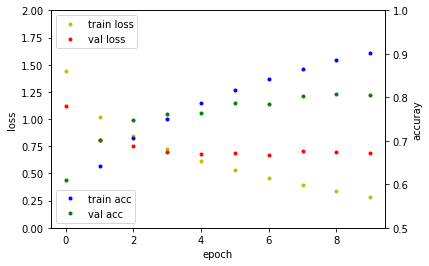

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32,32,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.25))

# model.add(Conv2D(128, (1, 1), activation='relu', padding="same"))
# model.add(Conv2D(128, (1, 1), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(GlobalAveragePooling2D())


model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train, 
                 epochs=10, batch_size=64, validation_data=(X_val, y_val))


# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots() 

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 2])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='upper right')


# 6. 모델 평가하기
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

epochs = 3
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=epochs)

# # here's a more "manual" example
# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32):
#         model.fit(X_batch, y_batch)
#         batches += 1
#         if batches >= len(X_train) / 32:
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break

Epoch 1/3
1563/1562 [==============================] - 51s 32ms/step - loss: 0.7000 - accuracy: 0.7608
Epoch 2/3
 329/1562 [=====>........................] - ETA: 40s - loss: 0.7086 - accuracy: 0.7578

In [60]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

10000/10000 [==============================] - 2s 200us/step
## evaluation loss and_metrics ##
[130.37657785644532, 0.2442999929189682]


In [ ]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(3)

from keras.preprocessing.image import ImageDataGenerator

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습시키기
model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=200,
        validation_data=test_generator,
        validation_steps=5)

# 모델 평가하기
print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            steps = 5)

print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 예측하기
print("-- Predict --")

output = model.predict_generator(
            test_generator, 
            steps = 5)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

TODO: Tell us what you did